In [ ]:
#default_exp data.block

In [ ]:
#export
from fastai2.torch_basics import *
from fastai2.data.core import *
from fastai2.data.load import *
from fastai2.data.external import *
from fastai2.data.transforms import *

In [ ]:
from nbdev.showdoc import *

# Data block

> High level API to quickly get your data in a `DataLoaders`

## TransformBlock -

In [ ]:
#export
class TransformBlock():
    "A basic wrapper that links defaults transforms for the data block API"
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =            L(type_tfms)
        self.item_tfms  = ToTensor + L(item_tfms)
        self.batch_tfms =            L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)

In [ ]:
#export
def CategoryBlock(vocab=None, add_na=False):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, add_na=add_na))

In [ ]:
#export
def MultiCategoryBlock(encoded=False, vocab=None, add_na=False):
    "`TransformBlock` for multi-label categorical targets"
    tfm = EncodedMultiCategorize(vocab=vocab) if encoded else [MultiCategorize(vocab=vocab, add_na=add_na), OneHotEncode]
    return TransformBlock(type_tfms=tfm)

In [ ]:
#export
def RegressionBlock(c_out=None):
    "`TransformBlock` for float targets"
    return TransformBlock(type_tfms=RegressionSetup(c_out))

## General API

In [ ]:
#export
from inspect import isfunction,ismethod

In [ ]:
#export
def _merge_tfms(*tfms):
    "Group the `tfms` in a single list, removing duplicates (from the same class) and instantiating"
    g = groupby(concat(*tfms), lambda o:
        o if isinstance(o, type) else o.__qualname__ if (isfunction(o) or ismethod(o)) else o.__class__)
    return L(v[-1] for k,v in g.items()).map(instantiate)

def _zip(x): return L(x).zip()    

In [ ]:
#For example, so not exported
from fastai2.vision.core import *
from fastai2.vision.data import *

In [ ]:
#hide
tfms = _merge_tfms([Categorize, MultiCategorize, Categorize(['dog', 'cat'])], Categorize(['a', 'b']))
#If there are several instantiated versions, the last one is kept.
test_eq(len(tfms), 2)
test_eq(tfms[1].__class__, MultiCategorize)
test_eq(tfms[0].__class__, Categorize)
test_eq(tfms[0].vocab, ['a', 'b'])

tfms = _merge_tfms([PILImage.create, PILImage.show])
#Check methods are properly separated
test_eq(len(tfms), 2)
tfms = _merge_tfms([show_image, set_trace])
#Check functions are properly separated
test_eq(len(tfms), 2)

In [ ]:
#export
@docs
@funcs_kwargs
class DataBlock():
    "Generic container to quickly build `Datasets` and `DataLoaders`"
    get_x=get_items=splitter=get_y = None
    blocks,dl_type = (TransformBlock,TransformBlock),TfmdDL
    _methods = 'get_items splitter get_y get_x'.split()
    def __init__(self, blocks=None, dl_type=None, getters=None, n_inp=None, item_tfms=None, batch_tfms=None, **kwargs):
        blocks = L(self.blocks if blocks is None else blocks)
        blocks = L(b() if callable(b) else b for b in blocks)
        self.type_tfms = blocks.attrgot('type_tfms', L())
        self.default_item_tfms  = _merge_tfms(*blocks.attrgot('item_tfms',  L()))
        self.default_batch_tfms = _merge_tfms(*blocks.attrgot('batch_tfms', L()))
        for b in blocks: 
            if getattr(b, 'dl_type', None) is not None: self.dl_type = b.dl_type
        if dl_type is not None: self.dl_type = dl_type
        self.dataloaders = delegates(self.dl_type.__init__)(self.dataloaders)
        self.dls_kwargs = merge(*blocks.attrgot('dls_kwargs', {}))
        
        self.getters = [noop] * len(self.type_tfms) if getters is None else getters
        if self.get_x: self.getters[0] = self.get_x
        if self.get_y: self.getters[1] = self.get_y
        self.n_inp = n_inp
        
        if kwargs: raise TypeError(f'invalid keyword arguments: {", ".join(kwargs.keys())}')
        self.new(item_tfms, batch_tfms)
        
    def _combine_type_tfms(self): return L([self.getters, self.type_tfms]).map_zip(lambda g,tt: L(g) + tt)
        
    def new(self, item_tfms=None, batch_tfms=None):
        self.item_tfms  = _merge_tfms(self.default_item_tfms,  item_tfms)
        self.batch_tfms = _merge_tfms(self.default_batch_tfms, batch_tfms)
        return self
    
    @classmethod
    def from_columns(cls, blocks=None, getters=None, get_items=None, **kwargs):
        if getters is None: getters = L(ItemGetter(i) for i in range(2 if blocks is None else len(L(blocks))))
        get_items = _zip if get_items is None else compose(get_items, _zip)
        return cls(blocks=blocks, getters=getters, get_items=get_items, **kwargs)

    def datasets(self, source, verbose=False):
        self.source = source                     ; pv(f"Collecting items from {source}", verbose)
        items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
        splits = (self.splitter or RandomSplitter())(items)  
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        return Datasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)

    def dataloaders(self, source, path='.', verbose=False, **kwargs):
        dsets = self.datasets(source)
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)

    _docs = dict(new="Create a new `DataBlock` with other `item_tfms` and `batch_tfms`",
                 datasets="Create a `Datasets` object from `source`",
                 dataloaders="Create a `DataLoaders` object from `source`")

To build a `DataBlock` you need to give the library four things: the types of your input/labels then at least two functions: `get_items` and `splitter`. You may also need to include `get_x` and `get_y` or a more generic list of `getters` that are applied to the results of `get_items`.

Once those are provided, you automatically get a `Datasets` or a `DataLoaders`:

In [ ]:
show_doc(DataBlock.datasets)

<h4 id="DataBlock.datasets" class="doc_header"><code>DataBlock.datasets</code><a href="__main__.py#L42" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.datasets</code>(**`source`**, **`verbose`**=*`False`*)

Create a [`Datasets`](/data.core#Datasets) object from `source`

In [ ]:
#hide_input
dblock = DataBlock()
show_doc(dblock.dataloaders, name="DataBlock.dataloaders")

<h4 id="DataBlock.dataloaders" class="doc_header"><code>DataBlock.dataloaders</code><a href="__main__.py#L49" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.dataloaders</code>(**`source`**, **`path`**=*`'.'`*, **`verbose`**=*`False`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`device`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create a [`DataLoaders`](/data.core#DataLoaders) object from `source`

You can create a `DataBlock` by passing functions:

In [ ]:
mnist = DataBlock(blocks = (ImageBlock(cls=PILImageBW),CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(),
                  get_y = parent_label)

Each type comes with default transforms that will be applied
- at the base level to create items in a tuple (usually input,target) from the base elements (like filenames)
- at the item level of the datasets
- at the batch level

They are called respectively type transforms, item transforms, batch transforms. In the case of MNIST, the type transforms are the method to create a `PILImageBW` (for the input) and the `Categorize` transform (for the target), the item transform is `ToTensor` and the batch transforms are `Cuda` and `IntToFloatTensor`. You can add any other transforms by passing them in `DataBlock.datasets` or `DataBlock.dataloaders`.

In [ ]:
test_eq(mnist.type_tfms[0], [PILImageBW.create])
test_eq(mnist.type_tfms[1].map(type), [Categorize])
test_eq(mnist.default_item_tfms.map(type), [ToTensor])
test_eq(mnist.default_batch_tfms.map(type), [IntToFloatTensor])

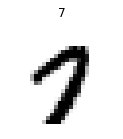

In [ ]:
dsets = mnist.datasets(untar_data(URLs.MNIST_TINY))
test_eq(dsets.vocab, ['3', '7'])
x,y = dsets.train[0]
test_eq(x.size,(28,28))
show_at(dsets.train, 0, cmap='Greys', figsize=(2,2));

In [ ]:
test_fail(lambda: DataBlock(wrong_kwarg=42, wrong_kwarg2='foo'))

## Debugging

In [ ]:
#export
def _short_repr(x):
    if isinstance(x, tuple): return f'({", ".join([_short_repr(y) for y in x])})'
    if isinstance(x, list): return f'[{", ".join([_short_repr(y) for y in x])}]'
    if not isinstance(x, Tensor): return str(x)
    if x.numel() <= 20 and x.ndim <=1: return str(x)
    return f'{x.__class__.__name__} of size {"x".join([str(d) for d in x.shape])}'

In [ ]:
#hide
test_eq(_short_repr(TensorImage(torch.randn(40,56))), 'TensorImage of size 40x56')
test_eq(_short_repr(TensorCategory([1,2,3])), 'TensorCategory([1, 2, 3])')
test_eq(_short_repr((TensorImage(torch.randn(40,56)), TensorImage(torch.randn(32,20)))),
        '(TensorImage of size 40x56, TensorImage of size 32x20)')

In [ ]:
#export
def _apply_pipeline(p, x):
    print(f"  {p}\n    starting from\n      {_short_repr(x)}")
    for f in p.fs: 
        name = f.name
        try:    
            x = f(x)
            if name != "noop": print(f"    applying {name} gives\n      {_short_repr(x)}")
        except Exception as e: 
            print(f"    applying {name} failed.")
            raise e
    return x

In [ ]:
#export
from fastai2.data.load import _collate_types

def _find_fail_collate(s):
    s = L(*s)
    for x in s[0]: 
        if not isinstance(x, _collate_types): return f"{type(x).__name__} is not collatable"
    for i in range_of(s[0]):
        try: _ = default_collate(s.itemgot(i))
        except:
            shapes = [getattr(o[i], 'shape', None) for o in s]
            return f"Could not collate the {i}-th members of your tuples because got the following shapes\n{','.join([str(s) for s in shapes])}"

In [ ]:
#export
@patch
def summary(self: DataBlock, source, bs=4, **kwargs):
    print(f"Setting-up type transforms pipelines")
    dsets = self.datasets(source, verbose=True)
    print("\nBuilding one sample")
    for tl in dsets.train.tls:
        _apply_pipeline(tl.tfms, get_first(dsets.train.items))
    print(f"\nFinal sample: {dsets.train[0]}\n\n")
    
    dls = self.dataloaders(source, verbose=True)
    print("\nBuilding one batch")
    if len([f for f in dls.train.after_item.fs if f.name != 'noop'])!=0:
        print("Applying item_tfms to the first sample:")
        s = [_apply_pipeline(dls.train.after_item, dsets.train[0])]
        print(f"\nAdding the next {bs-1} samples")
        s += [dls.train.after_item(dsets.train[i]) for i in range(1, bs)]
    else:
        print("No item_tfms to apply")
        s = [dls.train.after_item(dsets.train[i]) for i in range(bs)]
    
    if len([f for f in dls.train.before_batch.fs if f.name != 'noop'])!=0:
        print("\nApplying before_batch to the list of samples")
        s = _apply_pipeline(dls.train.before_batch, s)
    else: print("\nNo before_batch transform to apply")
    
    print("\nCollating items in a batch")
    try:
        b = dls.train.create_batch(s)
        b = retain_types(b, s[0] if is_listy(s) else s)
    except Exception as e:
        print("Error! It's not possible to collate your items in a batch")
        why = _find_fail_collate(s)
        print("Make sure all parts of your samples are tensors of the same size" if why is None else why)
        raise e
    
    if len([f for f in dls.train.after_batch.fs if f.name != 'noop'])!=0:
        print("\nApplying batch_tfms to the batch built")
        b = to_device(b, dls.device)
        b = _apply_pipeline(dls.train.after_batch, b)
    else: print("\nNo batch_tfms to apply")

In [ ]:
show_doc(DataBlock.summary)

<h4 id="DataBlock.summary" class="doc_header"><code>DataBlock.summary</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.summary</code>(**`source`**, **`bs`**=*`4`*, **\*\*`kwargs`**)



## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 13a_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 19_callback.mixup.ipynb.
Converted 20_interpret.ipynb.
Converted 20a_distributed.ipynb.
Converted 21_vision.learner.ipynb.
Converted 22_tutorial.imagenette.ipynb.
Converted 23_tutoria